# Plotting

In [1]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif", "font.size": 12})
import numpy as np

import qiskit
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import qasm3

In [2]:
fragment: str = "atp_0_be2_f4"

In [3]:
sqd_iterations = [1, 2, 3, 5]

In [4]:
all_sqd_energies = []
for i in sqd_iterations:
    energies = np.loadtxt(f"./{fragment}/sqd_energies/sqd_energies_{i}_adaptiterations.txt")
    all_sqd_energies.append(energies)

In [5]:
isqd_iterations = ["1", "1_2", "1_2_3", "1_2_3_4_5"]

In [6]:
all_isqd_energies = []
for i in isqd_iterations:
    energies = np.loadtxt(f"./{fragment}/sqd_energies/sqd_energies_{i}_adaptiterations.txt")
    all_isqd_energies.append(energies)

In [7]:
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend("ibm_boston")
sampler = Sampler(computer)

totals = []
for i in sqd_iterations:
    circuit_dir =  "circuits"
    circuit_fname = f"{fragment}_{i:03d}_adaptiterations.qasm"
    circuit_path = f"../{circuit_dir}/{fragment}/{circuit_fname}"
    circuit = qasm3.load(circuit_path)

    base = circuit.copy()
    base = qiskit.transpiler.passes.RemoveBarriers()(base)

    to_run = base.copy()
    to_run.measure_all()
    to_run = [to_run]

    to_run = qiskit.transpile(
        to_run,
        optimization_level=3,
        backend=computer,
        # initial_layout=qubits,  # TODO: Gate counts may differ from actual run because qubits aren't specified.
        seed_transpiler=123
    )
    total_gates = sum(to_run[0].count_ops().values())
    totals.append(total_gates)

In [8]:
totals

[188, 329, 414, 745]

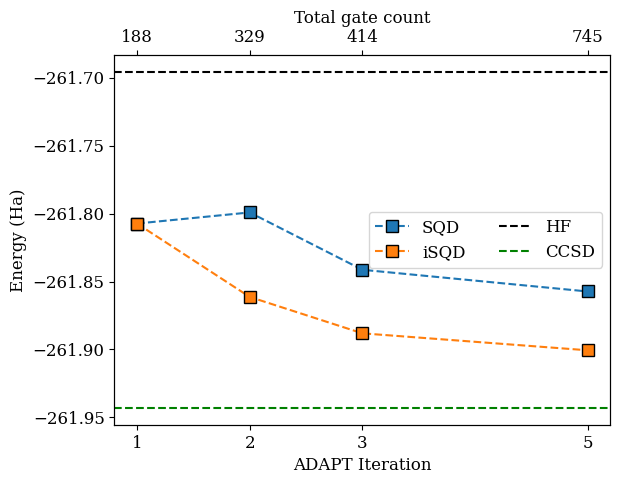

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


ax.plot(
    sqd_iterations,
    [np.min(e) for e in all_sqd_energies],
    "--s",
    ms=8,
    mec="black",
    label="SQD",
)
ax.plot(
    sqd_iterations,
    [np.min(e) for e in all_isqd_energies],
    "--s",
    ms=8,
    mec="black",
    label="iSQD",
)
# ax.axhline(np.min(np.loadtxt("sqd_energies_random_100000_bitstrings.txt")), color="black", ls="--", label="Random sampling")
ax.axhline(np.loadtxt(f"./{fragment}/hf_energy.txt"), color="black", ls="--", label="HF")
ax.axhline(np.loadtxt(f"./{fragment}/ccsd_energy.txt"), color="green", ls="--", label="CCSD")
ax.set_xlabel("ADAPT Iteration")
ax.set_xticks(sqd_iterations)
ax.set_xticklabels(sqd_iterations)
ax.set_ylabel("Energy (Ha)")
ax.legend(ncol=2);

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(sqd_iterations)
ax_top.set_xticklabels(totals)
ax_top.set_xlabel("Total gate count");